<a href="https://colab.research.google.com/github/Ishita0807/Automobile-Sales-Service-Analytics/blob/main/Automobile_sales_and_service_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

sales_df = pd.read_csv("/content/drive/MyDrive/automobile_sales_clean.csv")
service_df = pd.read_csv("/content/drive/MyDrive/automobile_service_clean.csv")

sales_df['Date'] = pd.to_datetime(sales_df['Date'])
service_df['Date'] = pd.to_datetime(service_df['Date'])

sales_df.head(), service_df.head()


(  Sale_ID       Date Region  Dealer_Name Vehicle_Model Brand    Price  \
 0    S001 2023-12-01   West  Wheels Auto         Sonet   Kia   814440   
 1    S002 2023-10-20   East       SpeedX         Sonet   Kia  1129495   
 2    S003 2023-04-01   West       SpeedX        Seltos   Kia  1224916   
 3    S004 2023-03-22  South     DriveNow        Seltos   Kia  1543512   
 4    S005 2023-06-22  South   Metro Cars           EV6   Kia   975711   
 
    Quantity Sale_Type  Year  Month  Quarter  Vehicle_Age  
 0         1      Used  2023     12        4            0  
 1         1       New  2023     10        4            0  
 2         1      Used  2023      4        2            0  
 3         1      Used  2023      3        1            0  
 4         1       New  2023      6        2            0  ,
   Service_ID       Date Region   Dealer_Name Vehicle_Model  \
 0      SV001 2023-03-27  South   Wheels Auto         Nexon   
 1      SV002 2023-06-16  South  Elite Motors        Baleno   
 2  

In [ ]:
print("SALES INFO")
print(sales_df.info())
print("\nSERVICE INFO")
print(service_df.info())

print("\nSALES MISSING VALUES")
print(sales_df.isna().sum())
print("\nSERVICE MISSING VALUES")
print(service_df.isna().sum())

print("\nSALES DESCRIPTIVE STATS")
print(sales_df[['Price','Quantity']].describe())

print("\nSERVICE DESCRIPTIVE STATS")
print(service_df[['Cost','Resolution_Time_Hrs','Customer_Satisfaction']].describe())


SALES INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Sale_ID        100 non-null    object        
 1   Date           100 non-null    datetime64[ns]
 2   Region         100 non-null    object        
 3   Dealer_Name    100 non-null    object        
 4   Vehicle_Model  100 non-null    object        
 5   Brand          100 non-null    object        
 6   Price          100 non-null    int64         
 7   Quantity       100 non-null    int64         
 8   Sale_Type      100 non-null    object        
 9   Year           100 non-null    int64         
 10  Month          100 non-null    int64         
 11  Quarter        100 non-null    int64         
 12  Vehicle_Age    100 non-null    int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 10.3+ KB
None

SERVICE INFO
<class 'pandas.core.frame.DataF

In [ ]:

if 'Year' not in sales_df.columns:
    sales_df['Year'] = sales_df['Date'].dt.year
    sales_df['Month'] = sales_df['Date'].dt.month
    sales_df['Quarter'] = sales_df['Date'].dt.quarter

if 'Year' not in service_df.columns:
    service_df['Year'] = service_df['Date'].dt.year
    service_df['Month'] = service_df['Date'].dt.month
    service_df['Quarter'] = service_df['Date'].dt.quarter

# Daily revenue
sales_df['Revenue'] = sales_df['Price'] * sales_df['Quantity']

# High satisfaction flag
service_df['High_Satisfaction'] = (service_df['Customer_Satisfaction'] >= 4).astype(int)


/tmp/ipython-input-190671901.py:11: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


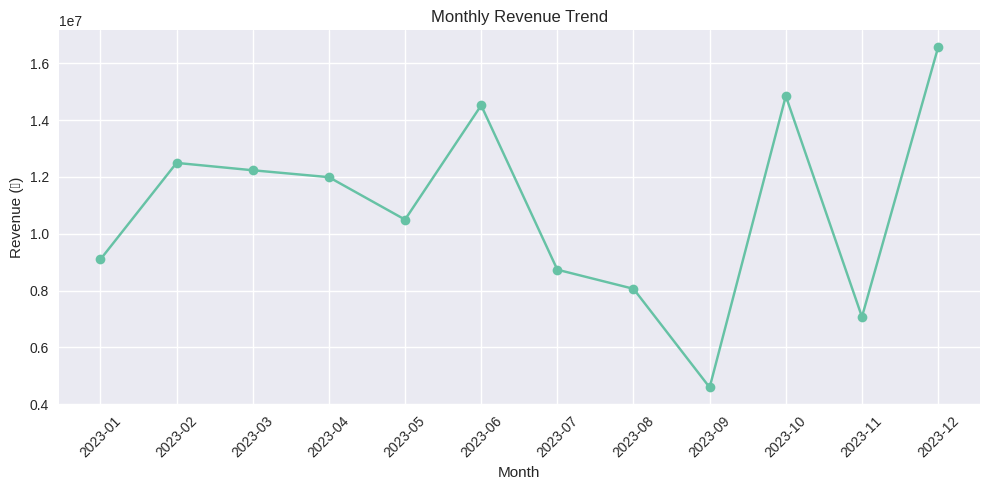

In [ ]:
sales_df['Month_Period'] = sales_df['Date'].dt.to_period('M')
monthly_revenue = sales_df.groupby('Month_Period')['Revenue'].sum().reset_index()

plt.figure(figsize=(10,5))
plt.plot(monthly_revenue['Month_Period'].astype(str), monthly_revenue['Revenue'], marker='o')
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2415386145.py:8: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


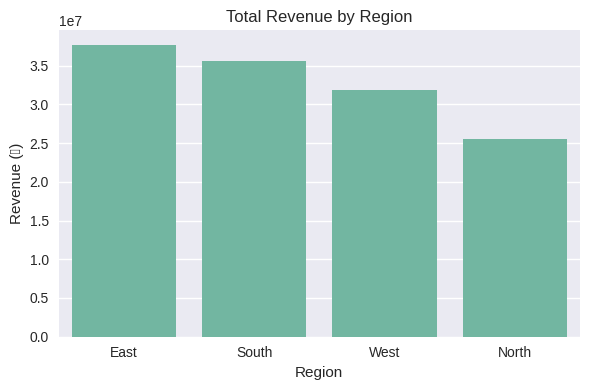

Region
East     37666798
South    35651406
West     31901085
North    25505758
Name: Revenue, dtype: int64


In [ ]:
region_revenue = sales_df.groupby('Region')['Revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=region_revenue.index, y=region_revenue.values)
plt.title("Total Revenue by Region")
plt.xlabel("Region")
plt.ylabel("Revenue (₹)")
plt.tight_layout()
plt.show()

print(region_revenue)


/tmp/ipython-input-671680470.py:9: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


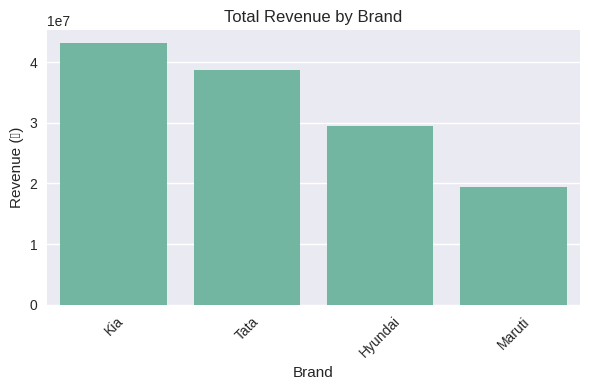

Brand
Kia        43109781
Tata       38699216
Hyundai    29485199
Maruti     19430851
Name: Revenue, dtype: int64


In [ ]:
brand_revenue = sales_df.groupby('Brand')['Revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=brand_revenue.index, y=brand_revenue.values)
plt.title("Total Revenue by Brand")
plt.xlabel("Brand")
plt.ylabel("Revenue (₹)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(brand_revenue)


/tmp/ipython-input-3714179257.py:9: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


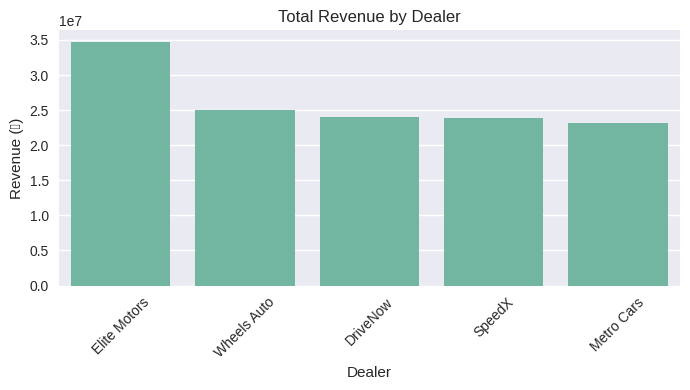

Dealer_Name
Elite Motors    34633212
Wheels Auto     24990076
DriveNow        24041523
SpeedX          23914830
Metro Cars      23145406
Name: Revenue, dtype: int64


In [ ]:
dealer_revenue = sales_df.groupby('Dealer_Name')['Revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(x=dealer_revenue.index, y=dealer_revenue.values)
plt.title("Total Revenue by Dealer")
plt.xlabel("Dealer")
plt.ylabel("Revenue (₹)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(dealer_revenue)


/tmp/ipython-input-2476193881.py:10: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


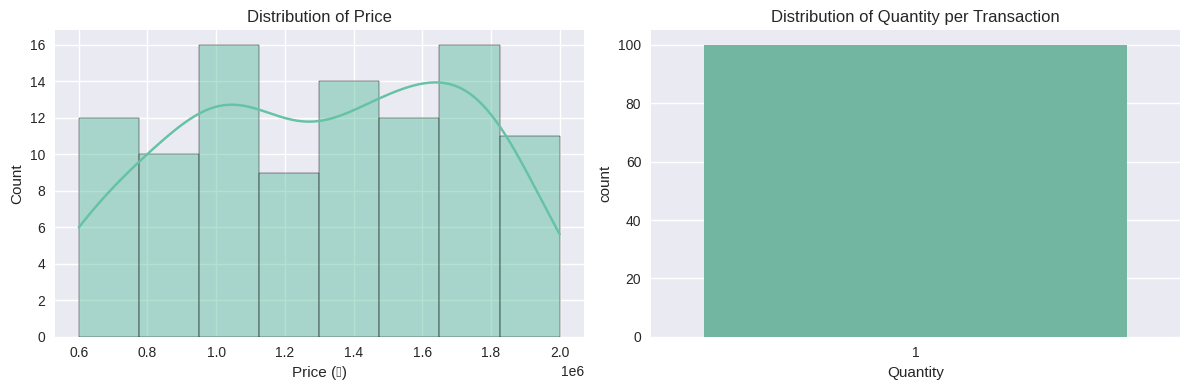

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(sales_df['Price'], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Price")
axes[0].set_xlabel("Price (₹)")

sns.countplot(x='Quantity', data=sales_df, ax=axes[1])
axes[1].set_title("Distribution of Quantity per Transaction")

plt.tight_layout()
plt.show()


**Service EDA & visualizations**

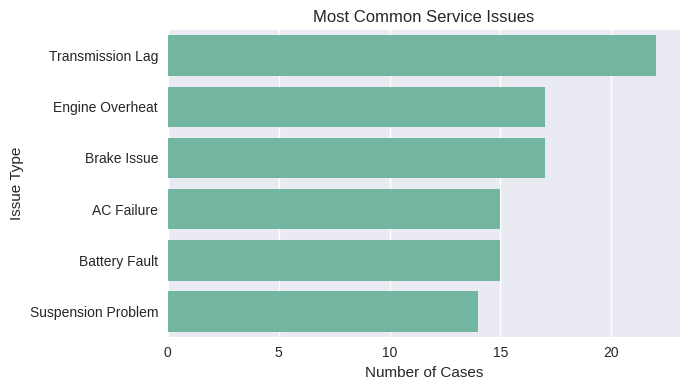

Issue_Type
Transmission Lag      22
Engine Overheat       17
Brake Issue           17
AC Failure            15
Battery Fault         15
Suspension Problem    14
Name: count, dtype: int64


In [ ]:
issue_counts = service_df['Issue_Type'].value_counts()

plt.figure(figsize=(7,4))
sns.barplot(x=issue_counts.values, y=issue_counts.index)
plt.title("Most Common Service Issues")
plt.xlabel("Number of Cases")
plt.ylabel("Issue Type")
plt.tight_layout()
plt.show()

print(issue_counts)


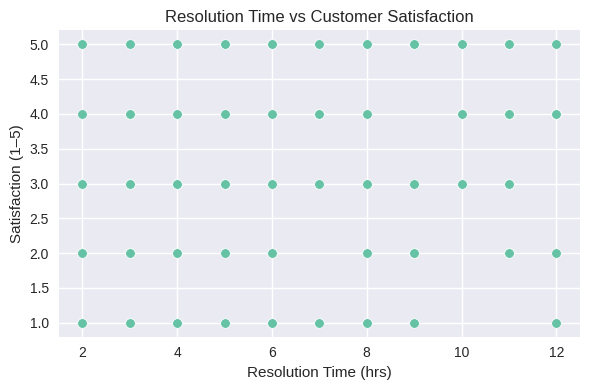

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='Resolution_Time_Hrs', y='Customer_Satisfaction', data=service_df)
plt.title("Resolution Time vs Customer Satisfaction")
plt.xlabel("Resolution Time (hrs)")
plt.ylabel("Satisfaction (1–5)")
plt.tight_layout()
plt.show()


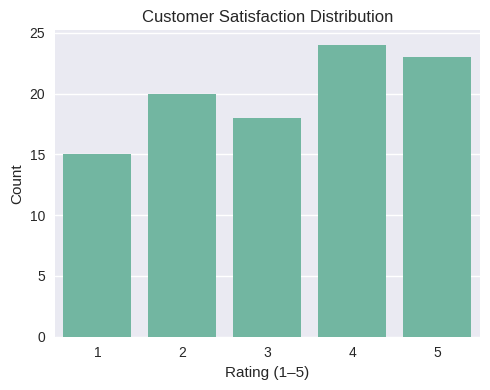

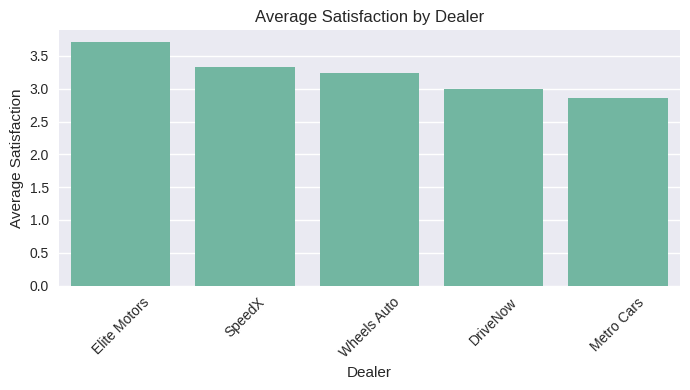

Dealer_Name
Elite Motors    3.705882
SpeedX          3.333333
Wheels Auto     3.238095
DriveNow        3.000000
Metro Cars      2.863636
Name: Customer_Satisfaction, dtype: float64


In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x='Customer_Satisfaction', data=service_df)
plt.title("Customer Satisfaction Distribution")
plt.xlabel("Rating (1–5)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

satisfaction_by_dealer = service_df.groupby('Dealer_Name')['Customer_Satisfaction'].mean().sort_values(ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(x=satisfaction_by_dealer.index, y=satisfaction_by_dealer.values)
plt.title("Average Satisfaction by Dealer")
plt.xlabel("Dealer")
plt.ylabel("Average Satisfaction")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(satisfaction_by_dealer)


/tmp/ipython-input-3398561201.py:11: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


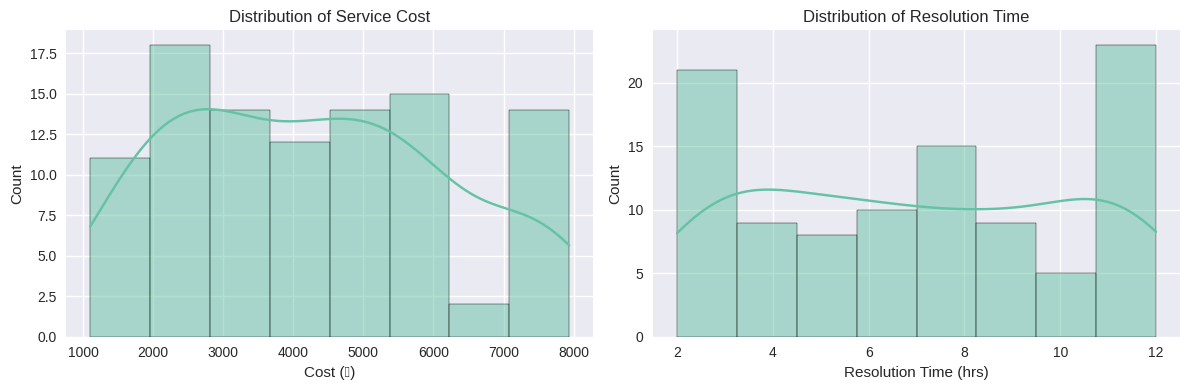

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(service_df['Cost'], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Service Cost")
axes[0].set_xlabel("Cost (₹)")

sns.histplot(service_df['Resolution_Time_Hrs'], kde=True, ax=axes[1])
axes[1].set_title("Distribution of Resolution Time")
axes[1].set_xlabel("Resolution Time (hrs)")

plt.tight_layout()
plt.show()


    Dealer_Name  Total_Revenue  Avg_Satisfaction
0      DriveNow       24041523          3.000000
1  Elite Motors       34633212          3.705882
2    Metro Cars       23145406          2.863636
3        SpeedX       23914830          3.333333
4   Wheels Auto       24990076          3.238095


/tmp/ipython-input-3502293070.py:17: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


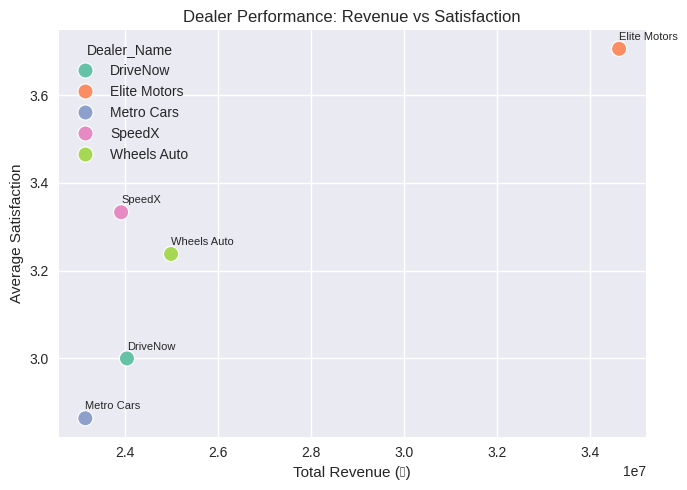

In [ ]:
sales_by_dealer = sales_df.groupby('Dealer_Name')['Revenue'].sum()
satisfaction_by_dealer = service_df.groupby('Dealer_Name')['Customer_Satisfaction'].mean()

dealer_summary = pd.concat([sales_by_dealer, satisfaction_by_dealer], axis=1).reset_index()
dealer_summary.columns = ['Dealer_Name', 'Total_Revenue', 'Avg_Satisfaction']

print(dealer_summary)

plt.figure(figsize=(7,5))
sns.scatterplot(data=dealer_summary, x='Total_Revenue', y='Avg_Satisfaction', hue='Dealer_Name', s=120)
for _, row in dealer_summary.iterrows():
    plt.text(row['Total_Revenue'], row['Avg_Satisfaction']+0.02, row['Dealer_Name'], fontsize=8)
plt.title("Dealer Performance: Revenue vs Satisfaction")
plt.xlabel("Total Revenue (₹)")
plt.ylabel("Average Satisfaction")
plt.grid(True)
plt.tight_layout()
plt.show()


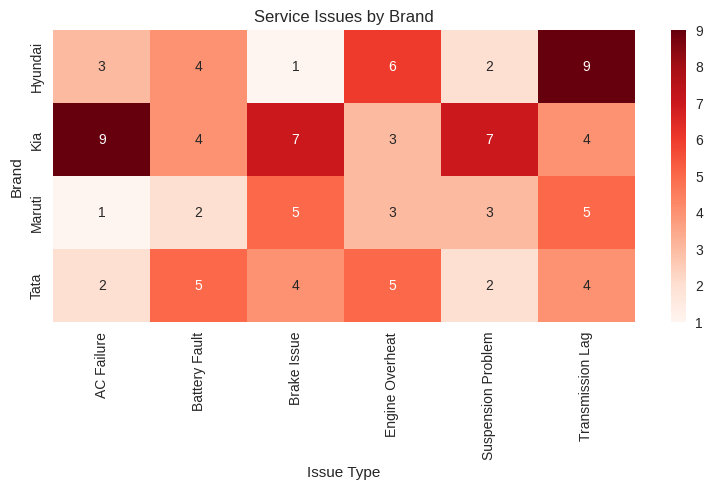

Issue_Type  AC Failure  Battery Fault  Brake Issue  Engine Overheat  \
Brand                                                                 
Hyundai              3              4            1                6   
Kia                  9              4            7                3   
Maruti               1              2            5                3   
Tata                 2              5            4                5   

Issue_Type  Suspension Problem  Transmission Lag  
Brand                                             
Hyundai                      2                 9  
Kia                          7                 4  
Maruti                       3                 5  
Tata                         2                 4  


In [ ]:

brand_issues = pd.merge(
    service_df,
    sales_df[['Vehicle_Model','Brand']].drop_duplicates(),
    on='Vehicle_Model',
    how='left'
)

issue_by_brand = pd.crosstab(brand_issues['Brand'], brand_issues['Issue_Type'])

plt.figure(figsize=(8,5))
sns.heatmap(issue_by_brand, annot=True, fmt='d', cmap='Reds')
plt.title("Service Issues by Brand")
plt.xlabel("Issue Type")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

print(issue_by_brand)
